# LLM Optimization based Language Feedback

Here we show a small example of how to apply `trace` to optimize python objects based on language feedback. Here we want to change the input to function `foobar` such that output is large enough. `foobar` is a function that is composed of `foo` based on built-in operators and `bar` which is a blackbox function, whose information is only given via the docstring.  



In [1]:
import autogen
from autogen.trace import trace_op, node
from autogen.trace.optimizers import FunctionOptimizer
from autogen.trace.nodes import GRAPH


def blackbox(x):
    return -x * 2


@trace_op()
def bar(x):
    "This is a test function, which does negative scaling."
    return blackbox(x)


def foo(x):
    y = x + 1
    return x * y


# foobar is a composition of custom function and built-in functions


def foobar(x):
    return foo(bar(x))


def user(x):
    if x < 50:
        return "The number needs to be larger."
    else:
        return "Success."

##Backpropagation 

We apply `FunctionOptimizer` to change the input to the function `foobar` such that the simulated user is satisfied. To this end, we backpropagated the user's language feedback about the output, through the graph that connects the input to the output.

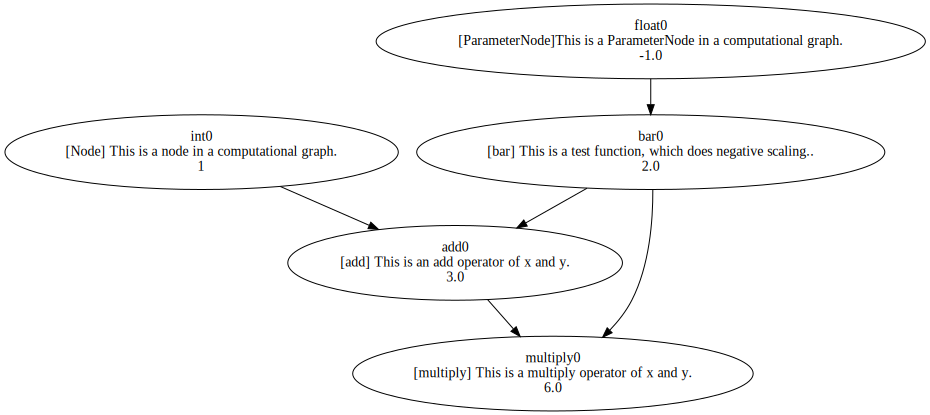

In [2]:
# One-step optimization example
x = node(-1.0, trainable=True)
optimizer = FunctionOptimizer([x], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))
output = foobar(x)
feedback = user(output.data)
optimizer.zero_feedback()
optimizer.backward(output, feedback, visualize=True)  # this is equivalent to the below line
# output.backward(feedback, propagator=optimizer.propagator, visualize=visualize)

The propagated feedback contains graph structure, data of the nodes in the graph, and the transformation used in the graph. They're presented in a python-like syntax.

In [3]:
from autogen.trace.utils import get_name

summary = optimizer.propagator.aggregate(x.feedback)

print("Graph:")
for k, v in sorted(summary.graph):
    print("  ", v)

print("Function definitions:")
for k, v in summary.documentation.items():
    print("  ", v)

print("Others:")
for k, v in summary.others.items():
    print("  ", f"{k}={v}")

print("Output")
for k, v in summary.output.items():
    print("  ", f"{k}={v}")

print("User feedback")
print("  ", summary.user_feedback)

print("Variable")
print("  ", f"{get_name(x)}={x.data}")

Graph:
   bar0 = bar(float0)
   add0 = add(bar0, int0)
   multiply0 = multiply(bar0, add0)
Function definitions:
   [multiply] This is a multiply operator of x and y.
   [add] This is an add operator of x and y.
   [bar] This is a test function, which does negative scaling..
Others:
   add0=3.0
   bar0=2.0
Output
   multiply0=6.0
User feedback
   The number needs to be larger.
Variable
   float0=-1.0


Once the feedback is propagated, we can call the optimization to change the variable based on the feedback.

In [4]:
old_variable = x.data
optimizer.step(verbose=True)

print("\nAfter step")
print("old variable", old_variable)
print("new variable", x.data)

Prompt
 
You're tasked debug and solve a coding/algorithm problem. You will see the code, the documentation of each function used in the code, and the feedback about the code's execution result.

Specifically, a problem will be composed of the following parts:
- #Code: the code whose results you need to improve.
- #Documentation: the documentation of each function used in the code.
- #Variables: the values of the variables that you need to change.
- #Outputs: the result of the code.
- #Others: the values of other inputs to the code, or intermediate values created through the code.
- #Feedback: the feedback about the code's execution result.

In #Variables, #Outputs, and #Others, the format is:
<type> <variable_name> = <value>
You need to change the values of the variables in #Variables to improve the code's output in accordance to #Feedback and their data types.
The explanation in #Documentation might be incomplete and just contain high-level description of each function. You can use t

# Example of Full Optimization Loop

We can apply the steps above repetitively to create a training loop to optimize the variable according to the user. Notice because of the way `foobar` works, the optimizer actually needs to change the input to be lower in order to make the output to be larger (which is what the user suggests). 

This is a non-trivial problem, becasue the optimizer sees only

```
output = blackbox(x) * (blackbox(x)+1)
```

and the hint/docstring `"This is a test function, which does scaling and negation."` about how `blackbox` works. The optimizer needs to figure out how to change the input based on this vague information.



In [5]:
# A small example of how to use the optimizer in a loop
GRAPH.clear()
x = node(-1.0, trainable=True)
optimizer = FunctionOptimizer([x], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

history = [x.data]
feedback = ""
while feedback.lower() != "Success.".lower():
    output = foobar(x)
    feedback = user(output.data)
    optimizer.zero_feedback()
    optimizer.backward(output, feedback)
    print(f"variable={x.data}, output={output.data}, feedback={feedback}")  # logging
    optimizer.step()
    history.append(x.data)  # logging

print("History")
for i, v in enumerate(history):
    print(f"  {i}: {v}")

variable=-1.0, output=6.0, feedback=The number needs to be larger.
variable=-2.0, output=20.0, feedback=The number needs to be larger.
variable=-3.0, output=42.0, feedback=The number needs to be larger.
variable=-5.0, output=110.0, feedback=Success.
History
  0: -1.0
  1: -2.0
  2: -3.0
  3: -5.0
  4: -5.0


# Example of optimizing strings

Below is a similar example, except the variable is written in text and is converted by a poor converter to numbers before inputting to `foo` and `bar`.

In [6]:
@trace_op()
def convert_english_to_numbers(x):
    """This is a function that converts English to numbers. This function has limited ability."""
    # remove speical characters, like, ", &, etc.
    x = x.replace('"', "")
    try:  # Convert string to integer
        return int(x)
    except:
        pass
    # Convert intergers written in Engligsh in [-10, 10] to numbers
    if x == "negative ten":
        return -10
    if x == "negative nine":
        return -9
    if x == "negative eight":
        return -8
    if x == "negative seven":
        return -7
    if x == "negative six":
        return -6
    if x == "negative five":
        return -5
    if x == "negative four":
        return -4
    if x == "negative three":
        return -3
    if x == "negative two":
        return -2
    if x == "negative one":
        return -1
    if x == "zero":
        return 0
    if x == "one":
        return 1
    if x == "two":
        return 2
    if x == "three":
        return 3
    if x == "four":
        return 4
    if x == "five":
        return 5
    if x == "six":
        return 6
    if x == "seven":
        return 7
    if x == "eight":
        return 8
    if x == "nine":
        return 9
    if x == "ten":
        return 10
    return "FAIL"


def user(x):
    if x == "FAIL":
        return "The text cannot be converted to a number."
    if x < 50:
        return "The number needs to be larger."
    else:
        return "Success."


def foobar_text(x):
    output = convert_english_to_numbers(x)
    if output.data == "FAIL":  # This is not traced
        return output
    else:
        return foo(bar(output))

In [7]:
GRAPH.clear()
x = node("negative point one", trainable=True)
optimizer = FunctionOptimizer([x], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

history = [x.data]
feedback = ""
while feedback.lower() != "Success.".lower():
    output = foobar_text(x)
    feedback = user(output.data)
    optimizer.zero_feedback()
    optimizer.backward(output, feedback)
    print(f"variable={x.data}, output={output.data}, feedback={feedback}")  # logging
    optimizer.step()
    history.append(x.data)  # logging

print("History")
for i, v in enumerate(history):
    print(f"  {i}: {v}")

variable=negative point one, output=FAIL, feedback=The text cannot be converted to a number.
variable="negative one", output=6, feedback=The number needs to be larger.
variable="negative one", output=6, feedback=The number needs to be larger.
variable="two", output=12, feedback=The number needs to be larger.
variable="three", output=30, feedback=The number needs to be larger.
variable="three", output=30, feedback=The number needs to be larger.
variable="seven", output=182, feedback=Success.
History
  0: negative point one
  1: "negative one"
  2: "negative one"
  3: "two"
  4: "three"
  5: "three"
  6: "seven"
  7: "seven"


/home/chinganc/codes/autogen/autogen/trace/optimizers.py:250: UserWarning: Node ParameterNode: (str:0, dtype=<class 'str'>, data="negative one") not found in the response #Reasoning
If we follow the code:
- convert_english_to_numbers function converts "negative one" (str0) to -1
- bar function does negative scaling, so it converts -1 to positive 1 (bar0)
- add function adds 1 (bar0) + 3 (int0) equal to 4 (add0)
- multiply function multiplies 1 (bar0) times 4 (add0) equal to 4 (multiply0)

As per the feedback, the final result, 4, (multiply0), is too small. We need a larger number. A good way to obtain a larger number would be to increase the value of int0 since this is directly involved in the addition operation that precedes the multiplication operation. 

#Suggestion
(int) int0 = 6
  warnings.warn(f"Node {node} not found in the response {response}")
/home/chinganc/codes/autogen/autogen/trace/optimizers.py:250: UserWarning: Node ParameterNode: (str:0, dtype=<class 'str'>, data="three"